In [1]:
import pyarrow.parquet as pq
import pandas as pd
import missingno as msno
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, confusion_matrix, roc_curve
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import GridSearchCV

import warnings
warnings.filterwarnings('ignore')

plt.style.use('fivethirtyeight')

In [2]:
# Задаем данные

target_file_path = "train_target.csv"
file_path = 'train_data/train_data_0.pq'

target_df = pd.read_csv(target_file_path)


table = pq.read_table(file_path)
df = table.to_pandas()
# Добавление столбца с таргетом
df = pd.merge(df, target_df[['id', 'flag']], on='id', how='left')

print(f"Обработка файла завершена.")

Обработка файла завершена.


id      0
flag    0
dtype: int64
________________________________


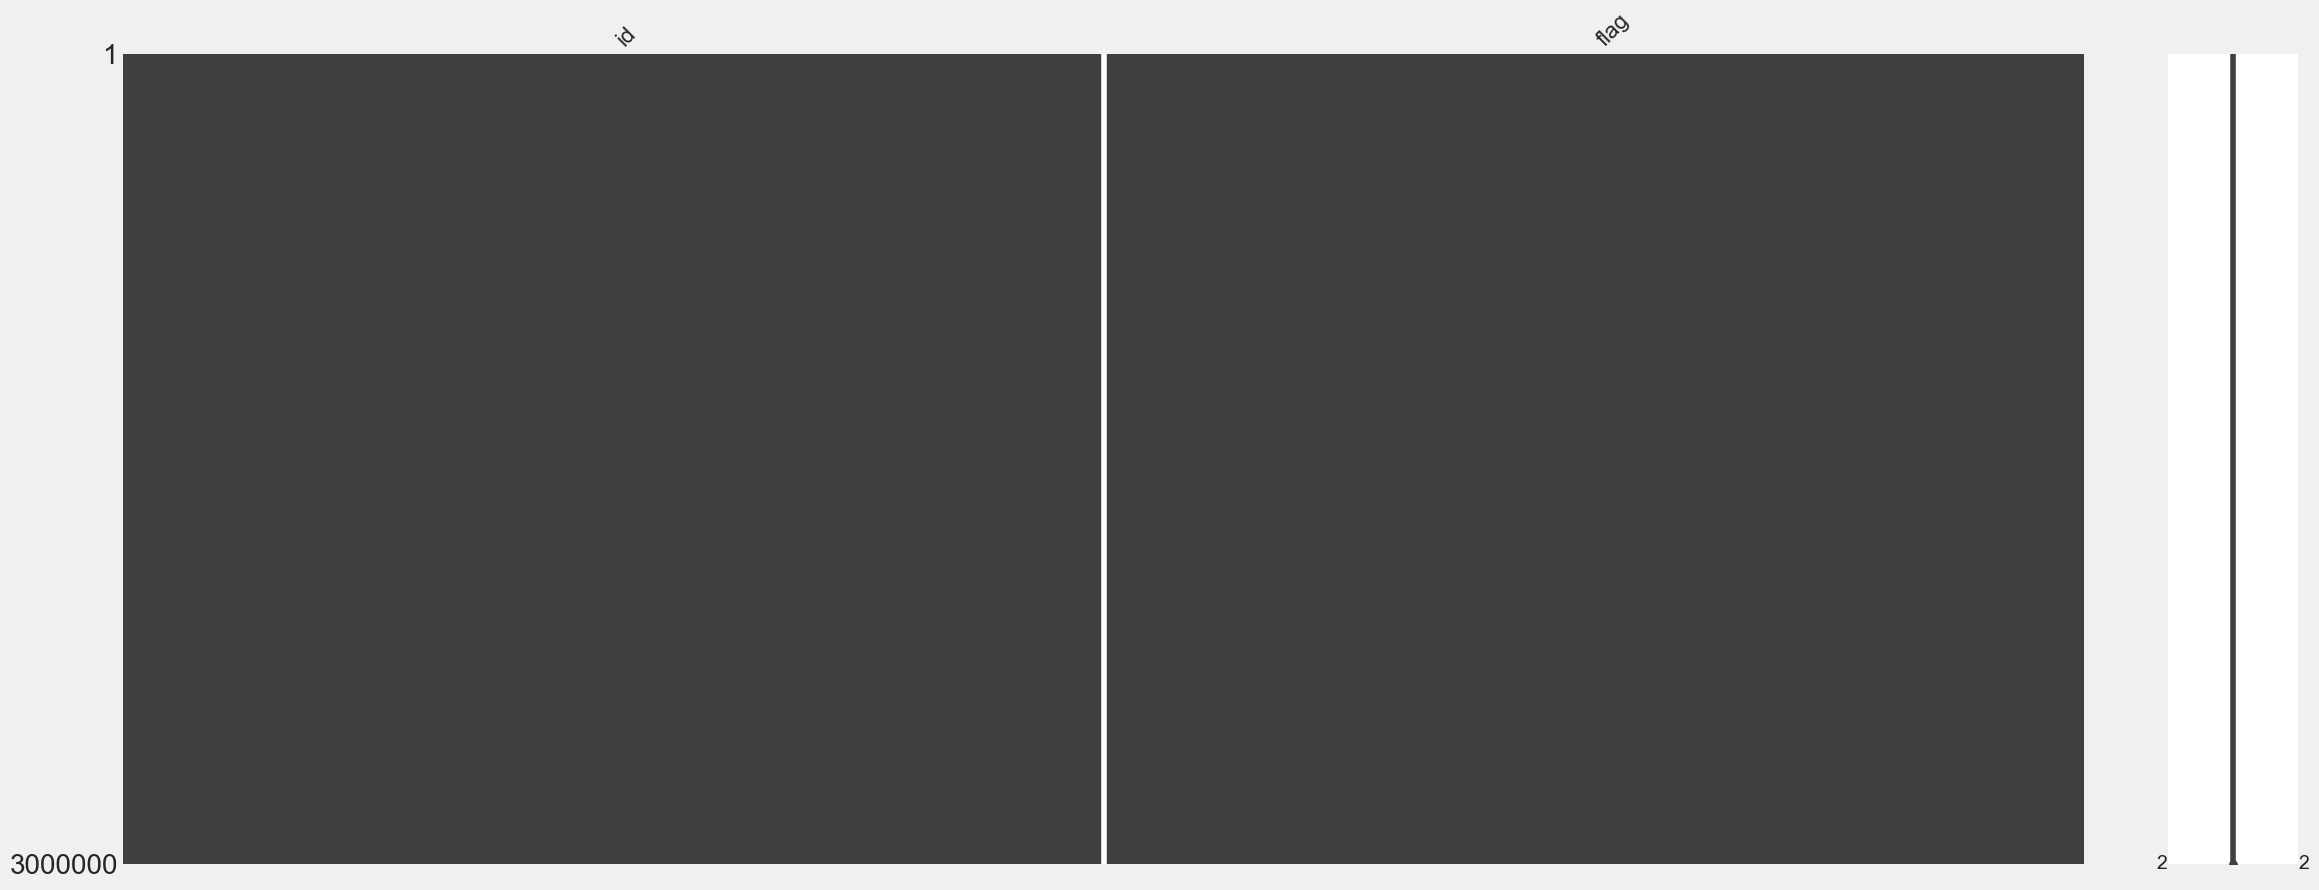

________________________________
Пропусков нет в данных.
________________________________
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000000 entries, 0 to 2999999
Data columns (total 2 columns):
 #   Column  Dtype
---  ------  -----
 0   id      int64
 1   flag    int64
dtypes: int64(2)
memory usage: 45.8 MB
________________________________
                 id          flag
count  3.000000e+06  3.000000e+06
mean   1.500000e+06  3.548067e-02
std    8.660255e+05  1.849914e-01
min    0.000000e+00  0.000000e+00
25%    7.499998e+05  0.000000e+00
50%    1.500000e+06  0.000000e+00
75%    2.249999e+06  0.000000e+00
max    2.999999e+06  1.000000e+00
________________________________
flag
0    2893558
1     106442
Name: count, dtype: int64
________________________________


In [3]:
# Смотрим пропуски

print(target_df.isna().sum())
print('________________________________')

# Смотрим пропуски на графике
msno.matrix(target_df)
plt.show()
print('________________________________')
# Пробуем найти даже 1 пропуск, который не видно на графике и можно было бы не заметить при просмотре вывода строки 3-4. 

missing_columns = target_df.columns[target_df.isnull().any()]

if missing_columns.empty:
    print("Пропусков нет в данных.")
else:
    print("Пропуски обнаружены в следующих столбцах:")
    for column in missing_columns:
        missing_count = target_df[column].isnull().sum()
        print(f"{column}: {missing_count} пропусков")
print('________________________________')

# Информация о датафрейме
target_df.info()
print('________________________________')
# Описание датафрейма
print(target_df.describe())
print('________________________________')
# Баланс классов целевой переменной
print(target_df['flag'].value_counts())
print('________________________________')


Предварительный план заключается в следующем: я загрузил все файлы в один датафрейм, получилось около 35гб занятой памяти, 26млн строк и 61 признак. Оставлять этот вывод наглядно не представляется возможным, если только создать отдельный юпитер файл и там это зафиксировать. Работать с таким размером теоретически можно, но операций по обработке может быть много, каждая из которых будет обновлять датафрейм. 

Из загрузки этих файлов можно сделать вывод, что они имеют одинаковую структуру, одинаковое количество признаков, не возникает никаких ошибок, когда они объединяются в один файл. Следовательно, можно просмотреть 1 файл, на его основе провести анализ и обработку и с помощью пайплайна обработать все остальные файлы. 

In [4]:
df

,id,rn,pre_since_opened,pre_since_confirmed,pre_pterm,pre_fterm,pre_till_pclose,pre_till_fclose,pre_loans_credit_limit,pre_loans_next_pay_summ,...,enc_paym_22,enc_paym_23,enc_paym_24,enc_loans_account_holder_type,enc_loans_credit_status,enc_loans_credit_type,enc_loans_account_cur,pclose_flag,fclose_flag,flag
0,0,1,18,9,2,3,16,10,11,3,...,3,3,4,1,3,4,1,0,0,0
1,0,2,18,9,14,14,12,12,0,3,...,0,0,4,1,3,4,1,0,0,0
2,0,3,18,9,4,8,1,11,11,0,...,0,0,4,1,2,3,1,1,1,0
3,0,4,4,1,9,12,16,7,12,2,...,3,3,4,1,3,1,1,0,0,0
4,0,5,5,12,15,2,11,12,10,2,...,3,3,4,1,3,4,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1974719,249998,4,1,9,14,8,10,11,8,4,...,3,3,4,1,2,3,1,0,1,0
1974720,249998,5,7,9,4,8,1,11,19,1,...,3,3,4,1,2,4,1,1,1,0
1974721,249999,1,9,0,10,8,10,11,16,2,...,3,3,4,1,2,3,1,0,1,0
1974722,249999,2,9,16,10,13,10,4,12,2,...,3,3,4,1,2,3,1,0,0,0


id                       0
rn                       0
pre_since_opened         0
pre_since_confirmed      0
pre_pterm                0
                        ..
enc_loans_credit_type    0
enc_loans_account_cur    0
pclose_flag              0
fclose_flag              0
flag                     0
Length: 62, dtype: int64
________________________________


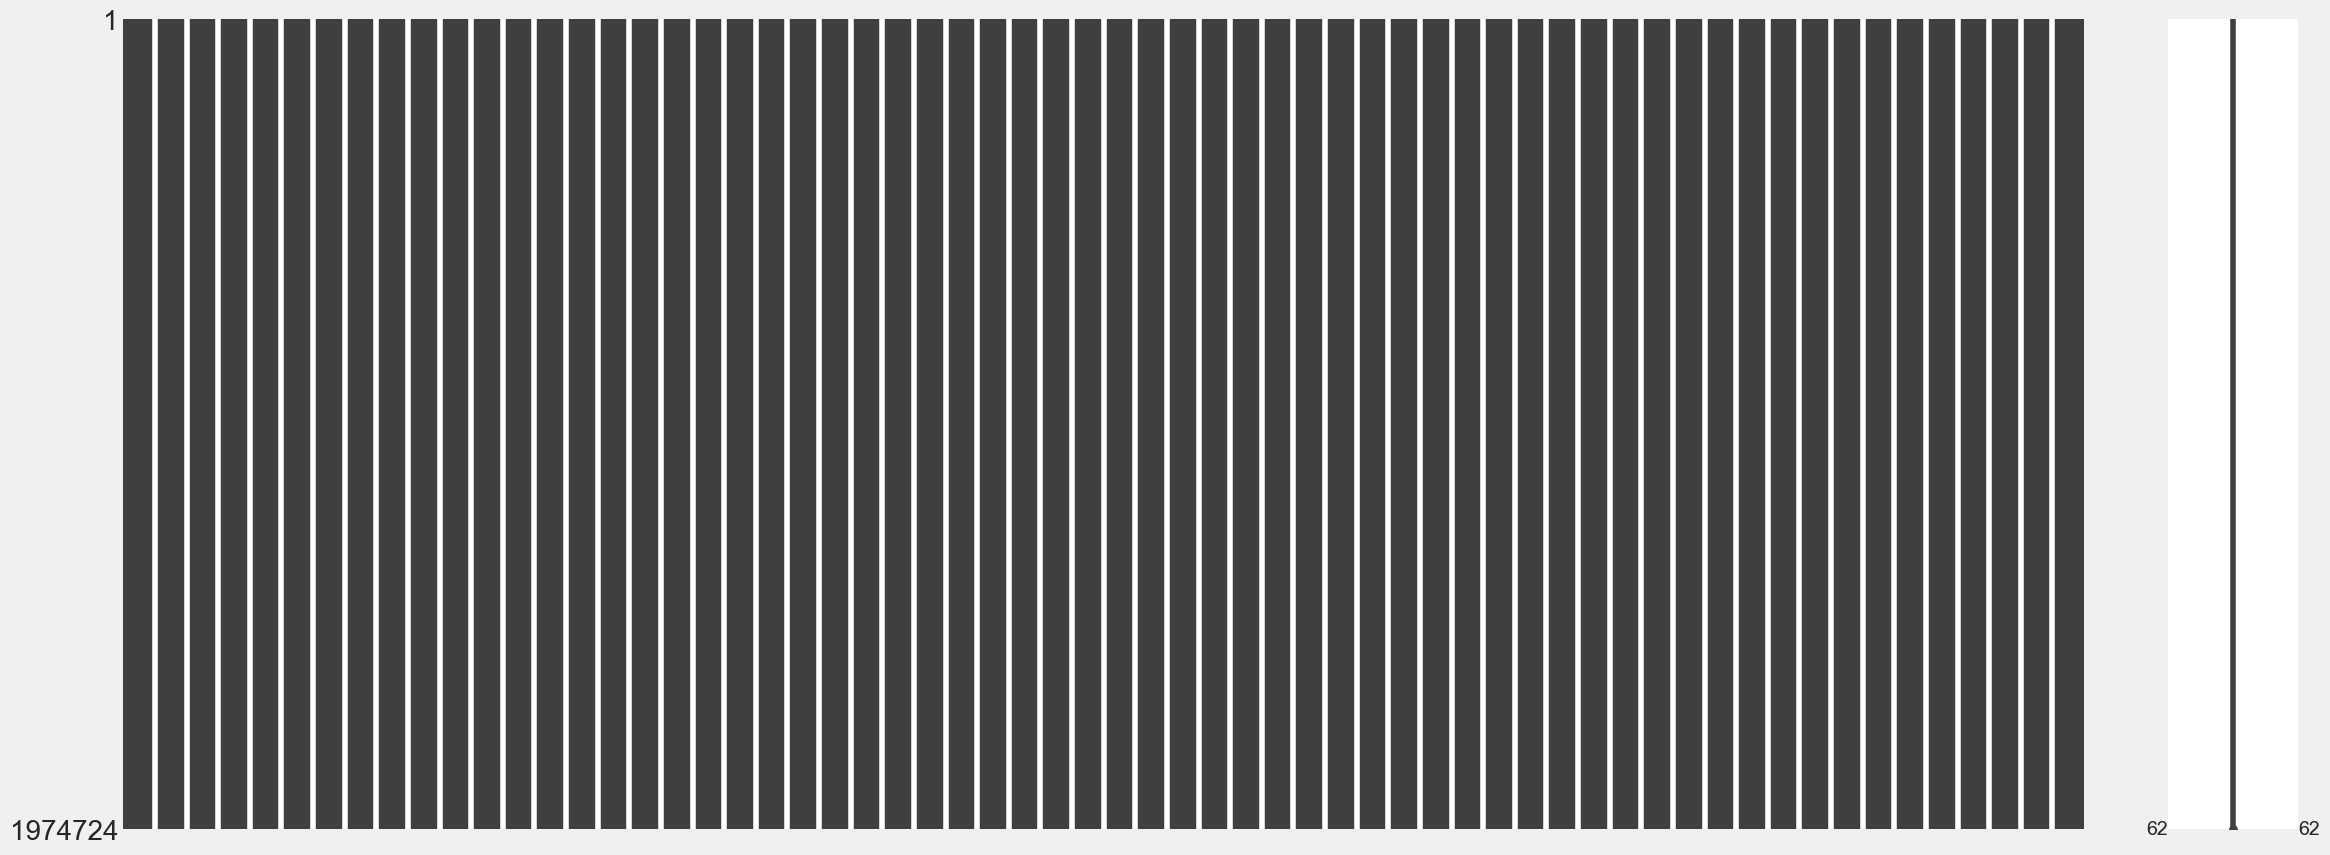

________________________________
Пропусков нет в данных.
________________________________
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1974724 entries, 0 to 1974723
Data columns (total 62 columns):
 #   Column                         Dtype
---  ------                         -----
 0   id                             int64
 1   rn                             int64
 2   pre_since_opened               int64
 3   pre_since_confirmed            int64
 4   pre_pterm                      int64
 5   pre_fterm                      int64
 6   pre_till_pclose                int64
 7   pre_till_fclose                int64
 8   pre_loans_credit_limit         int64
 9   pre_loans_next_pay_summ        int64
 10  pre_loans_outstanding          int64
 11  pre_loans_total_overdue        int64
 12  pre_loans_max_overdue_sum      int64
 13  pre_loans_credit_cost_rate     int64
 14  pre_loans5                     int64
 15  pre_loans530                   int64
 16  pre_loans3060                  int64

In [5]:
# Смотрим пропуски

print(df.isna().sum())
print('________________________________')
# Смотрим пропуски на графике
msno.matrix(df)
plt.show()
print('________________________________')
# Пробуем найти даже 1 пропуск, который не видно на графике и можно было бы не заметить при просмотре вывода строки 3-4. 
missing_columns = df.columns[df.isnull().any()]

if missing_columns.empty:
    print("Пропусков нет в данных.")
else:
    print("Пропуски обнаружены в следующих столбцах:")
    for column in missing_columns:
        missing_count = df[column].isnull().sum()
        print(f"{column}: {missing_count} пропусков")
print('________________________________')
# Информация о датафрейме
df.info()
print('________________________________')
# Описание датафрейма
print(df.describe())
print('________________________________')
# Баланс классов целевой переменной
print(df['flag'].value_counts())
print('________________________________')



In [6]:
numeric_columns = df.select_dtypes(include='number')

for column in numeric_columns.columns:
    non_numeric_values = pd.to_numeric(df[column], errors='coerce').isnull()
    if non_numeric_values.any():
        print(f"В колонке {column} содержатся значения, отличные от чисел.")
    else:
        print(f"Все значения численные")


Все значения численные
Все значения численные
Все значения численные
Все значения численные
Все значения численные
Все значения численные
Все значения численные
Все значения численные
Все значения численные
Все значения численные
Все значения численные
Все значения численные
Все значения численные
Все значения численные
Все значения численные
Все значения численные
Все значения численные
Все значения численные
Все значения численные
Все значения численные
Все значения численные
Все значения численные
Все значения численные
Все значения численные
Все значения численные
Все значения численные
Все значения численные
Все значения численные
Все значения численные
Все значения численные
Все значения численные
Все значения численные
Все значения численные
Все значения численные
Все значения численные
Все значения численные
Все значения численные
Все значения численные
Все значения численные
Все значения численные
Все значения численные
Все значения численные
Все значения численные
Все значени

В предварительном выводе можно отметить следующее: отсутствие пропусков, все признаки int64, отсутствие элементов отличающихся от чисел. Вероятно нельзя назвать какие-либо данные выбросами. 
Касательно целевой переменной все выводы применимы и к ней. Есть сильный дизбаланс классов. После объединения датафреймов дизбаланс становится еще более ощутимым. 

Построение матриц и других графиков на данный момент представляется слишком тяжелым процессом, поэтому займемся отбором признаков и уменьшением размерности по возможности. 

pre_since_opened - не имеет отношения к потенциальной возможности дефолта клиента. 
pre_since_confirmed - не имеет отношения к потенциальной возможности дефолта клиента. 
pre_till_pclose - не объясняется, что подразумевается под сбором данных. Я подозреваю, что признак может сильно коррелировать с количеством дней от открытия до закрытия кредита, и более того, второй признак более информативен, на мой взгляд. 
pre_till_fclose - е объясняется, что подразумевается под сбором данных. Я подозреваю, что признак может сильно коррелировать с количеством дней от открытия до закрытия кредита, и более того, второй признак более информативен, на мой взгляд. 
enc_paym_N - как я понял, эти фичи повторяются, в дальнейшем коде по корреляции видно, что почти все эти фичи в топе, и имеют одинаковый смысл, просто обновляются по мере прохождения отрезка времени. В таком случае, предлагаю оставить статусы платежей за 24 месяца, за 12 месяцев и за 3 месяца. 



In [7]:
new_corrs = []
columns = df.columns
# Итерируем по колонкам
for col in columns:
    # Считаем корреляцию с целевой переменной
    corr = df['flag'].corr(df[col])


    new_corrs.append((col, corr))

In [8]:
new_corrs = sorted(new_corrs, key = lambda x: abs(x[1]), reverse = True)
new_corrs[:20]

# Выводим отсортированную корреляцию для 20 признаков

[('pre_loans_total_overdue', nan),
 ('flag', 0.9999999999999999),
 ('enc_paym_2', 0.04695006442577298),
 ('enc_paym_1', 0.045095270320500966),
 ('enc_paym_3', 0.04442878954477112),
 ('enc_paym_4', 0.040137355573191855),
 ('is_zero_loans3060', -0.039092485999413396),
 ('enc_paym_5', 0.03672836846453012),
 ('is_zero_loans6090', -0.034809946539773325),
 ('is_zero_loans90', -0.033059291112084895),
 ('enc_paym_6', 0.03289782936488274),
 ('is_zero_loans530', -0.03204533014954323),
 ('enc_paym_7', 0.03112824200049668),
 ('enc_paym_0', 0.029502214453916938),
 ('enc_paym_8', 0.028992982189299882),
 ('enc_paym_9', 0.02751937162817799),
 ('enc_paym_10', 0.025143499048447197),
 ('enc_paym_11', 0.024400945325428133),
 ('enc_loans_credit_type', 0.02440009900349407),
 ('enc_paym_13', 0.0241562990402641)]

По корреляции видно, что самая высокая для признаков enc_paym_N, но может быть такое количество одинаковых признаков будет лишним. 

In [9]:
selected_features = ['enc_paym_3', 'enc_paym_12', 'enc_paym_24']

# Получаем список столбцов, которые нужно удалить
columns_to_drop = [col for col in df.columns if col.startswith('enc_paym_') and col not in selected_features]

df = df.drop(columns=columns_to_drop)


In [10]:
df = df.drop('pre_since_opened', axis=1)
df = df.drop('pre_since_confirmed', axis=1)
df = df.drop('pre_till_fclose', axis=1)
df = df.drop('pre_till_pclose', axis=1)
df = df.drop('id', axis=1)

In [11]:
# Посмотрим на корреляцию после удаления неинформативных на первый взгляд признаков

new_corrs_drop_enc = []
columns_after_drop = df.columns
# Итерируем по колонкам
for col in columns_after_drop:
    # Считаем корреляцию с целевой переменной
    corr = df['flag'].corr(df[col])


    new_corrs_drop_enc.append((col, corr))

new_corrs_drop_enc = sorted(new_corrs_drop_enc, key=lambda x: abs(x[1]), reverse=True)
new_corrs_drop_enc[:20]

[('pre_loans_total_overdue', nan),
 ('flag', 0.9999999999999999),
 ('enc_paym_3', 0.04442878954477112),
 ('is_zero_loans3060', -0.039092485999413396),
 ('is_zero_loans6090', -0.034809946539773325),
 ('is_zero_loans90', -0.033059291112084895),
 ('is_zero_loans530', -0.03204533014954323),
 ('enc_loans_credit_type', 0.02440009900349407),
 ('enc_paym_12', 0.02392256762946297),
 ('is_zero_maxover2limit', -0.022170520231092273),
 ('pre_maxover2limit', -0.02120617629939225),
 ('is_zero_loans5', -0.020380625223332123),
 ('pre_util', -0.015189084454089855),
 ('enc_paym_24', 0.014346836097231535),
 ('is_zero_util', -0.014336698424626964),
 ('pre_loans5', -0.012955910166246446),
 ('pre_loans_credit_limit', 0.009272493883057557),
 ('pre_loans_outstanding', 0.008985574612534467),
 ('pre_loans530', -0.0083856467280416),
 ('pre_fterm', -0.007913420603946692)]

In [12]:
duplicates = df.duplicated()

# Выводим строки с дубликатами
print("Строки с дубликатами:")
print(df[duplicates])

Строки с дубликатами:
         rn  pre_pterm  pre_fterm  pre_loans_credit_limit  \
357       1          8          6                      18   
735       2          7          6                       3   
840       1         13          0                       5   
946       9          3          5                      18   
1026      4          8         11                      13   
...      ..        ...        ...                     ...   
1974705  20          4          8                       4   
1974710   2         14         16                      15   
1974712   4          6         13                       2   
1974714   6          4          8                       9   
1974715   7          1          8                       6   

         pre_loans_next_pay_summ  pre_loans_outstanding  \
357                            2                      3   
735                            2                      3   
840                            2                      3   
946      

На данном этапе, мне кажется, нельзя как-либо группировать данные, для сокращения размерности и сжатия впоследствии целевой переменной. Объясняется это тем, что у нас есть строка данных, которая подразумевает под собой взятый кредит, конкретно этот кредит может не привести к дефолту, но если у человека был прецедент, значит какой-либо из имеющихся кредитов мог стать критическим для клиента. Поэтому определенный набор данных и их последовательность может иметь в себе ключ к конечному дефолту. Также и для 0, определенная последовательность в множестве кредитов может говорить о том, что клиент исправно вернет заем. 
К сожалению у нас нет данных какой кредит именно привел к дефолту, мы знаем только, что у клиента была проблема. Зная какой кредит именно, мы могли бы сократить размерность и вывести какие-либо новые признаки из имеющихся. 

In [13]:
# Подтверждаем сильный дизбаланс классов.

df['flag'].value_counts()

flag
0    1917618
1      57106
Name: count, dtype: int64

In [14]:
X = df.drop('flag', axis=1)
y = df['flag']

In [15]:
# Попробуем провести undersampling, возможно конкретно этот не лучший выбор, но его можно будет использовать для построения графиков, так как на оригинальных данных графики загружают память за 90гб. 
# Создание экземпляра RandomUnderSampler
rus = RandomUnderSampler()

# Применение уменьшения выборки к данным
X_downscaled, y_downscaled = rus.fit_resample(X, y)
print(X_downscaled.shape)
print('________________________________')

print(y_downscaled.shape)
print('________________________________')

print(y_downscaled.value_counts())
print('________________________________')

(114212, 34)
________________________________
(114212,)
________________________________
flag
0    57106
1    57106
Name: count, dtype: int64
________________________________


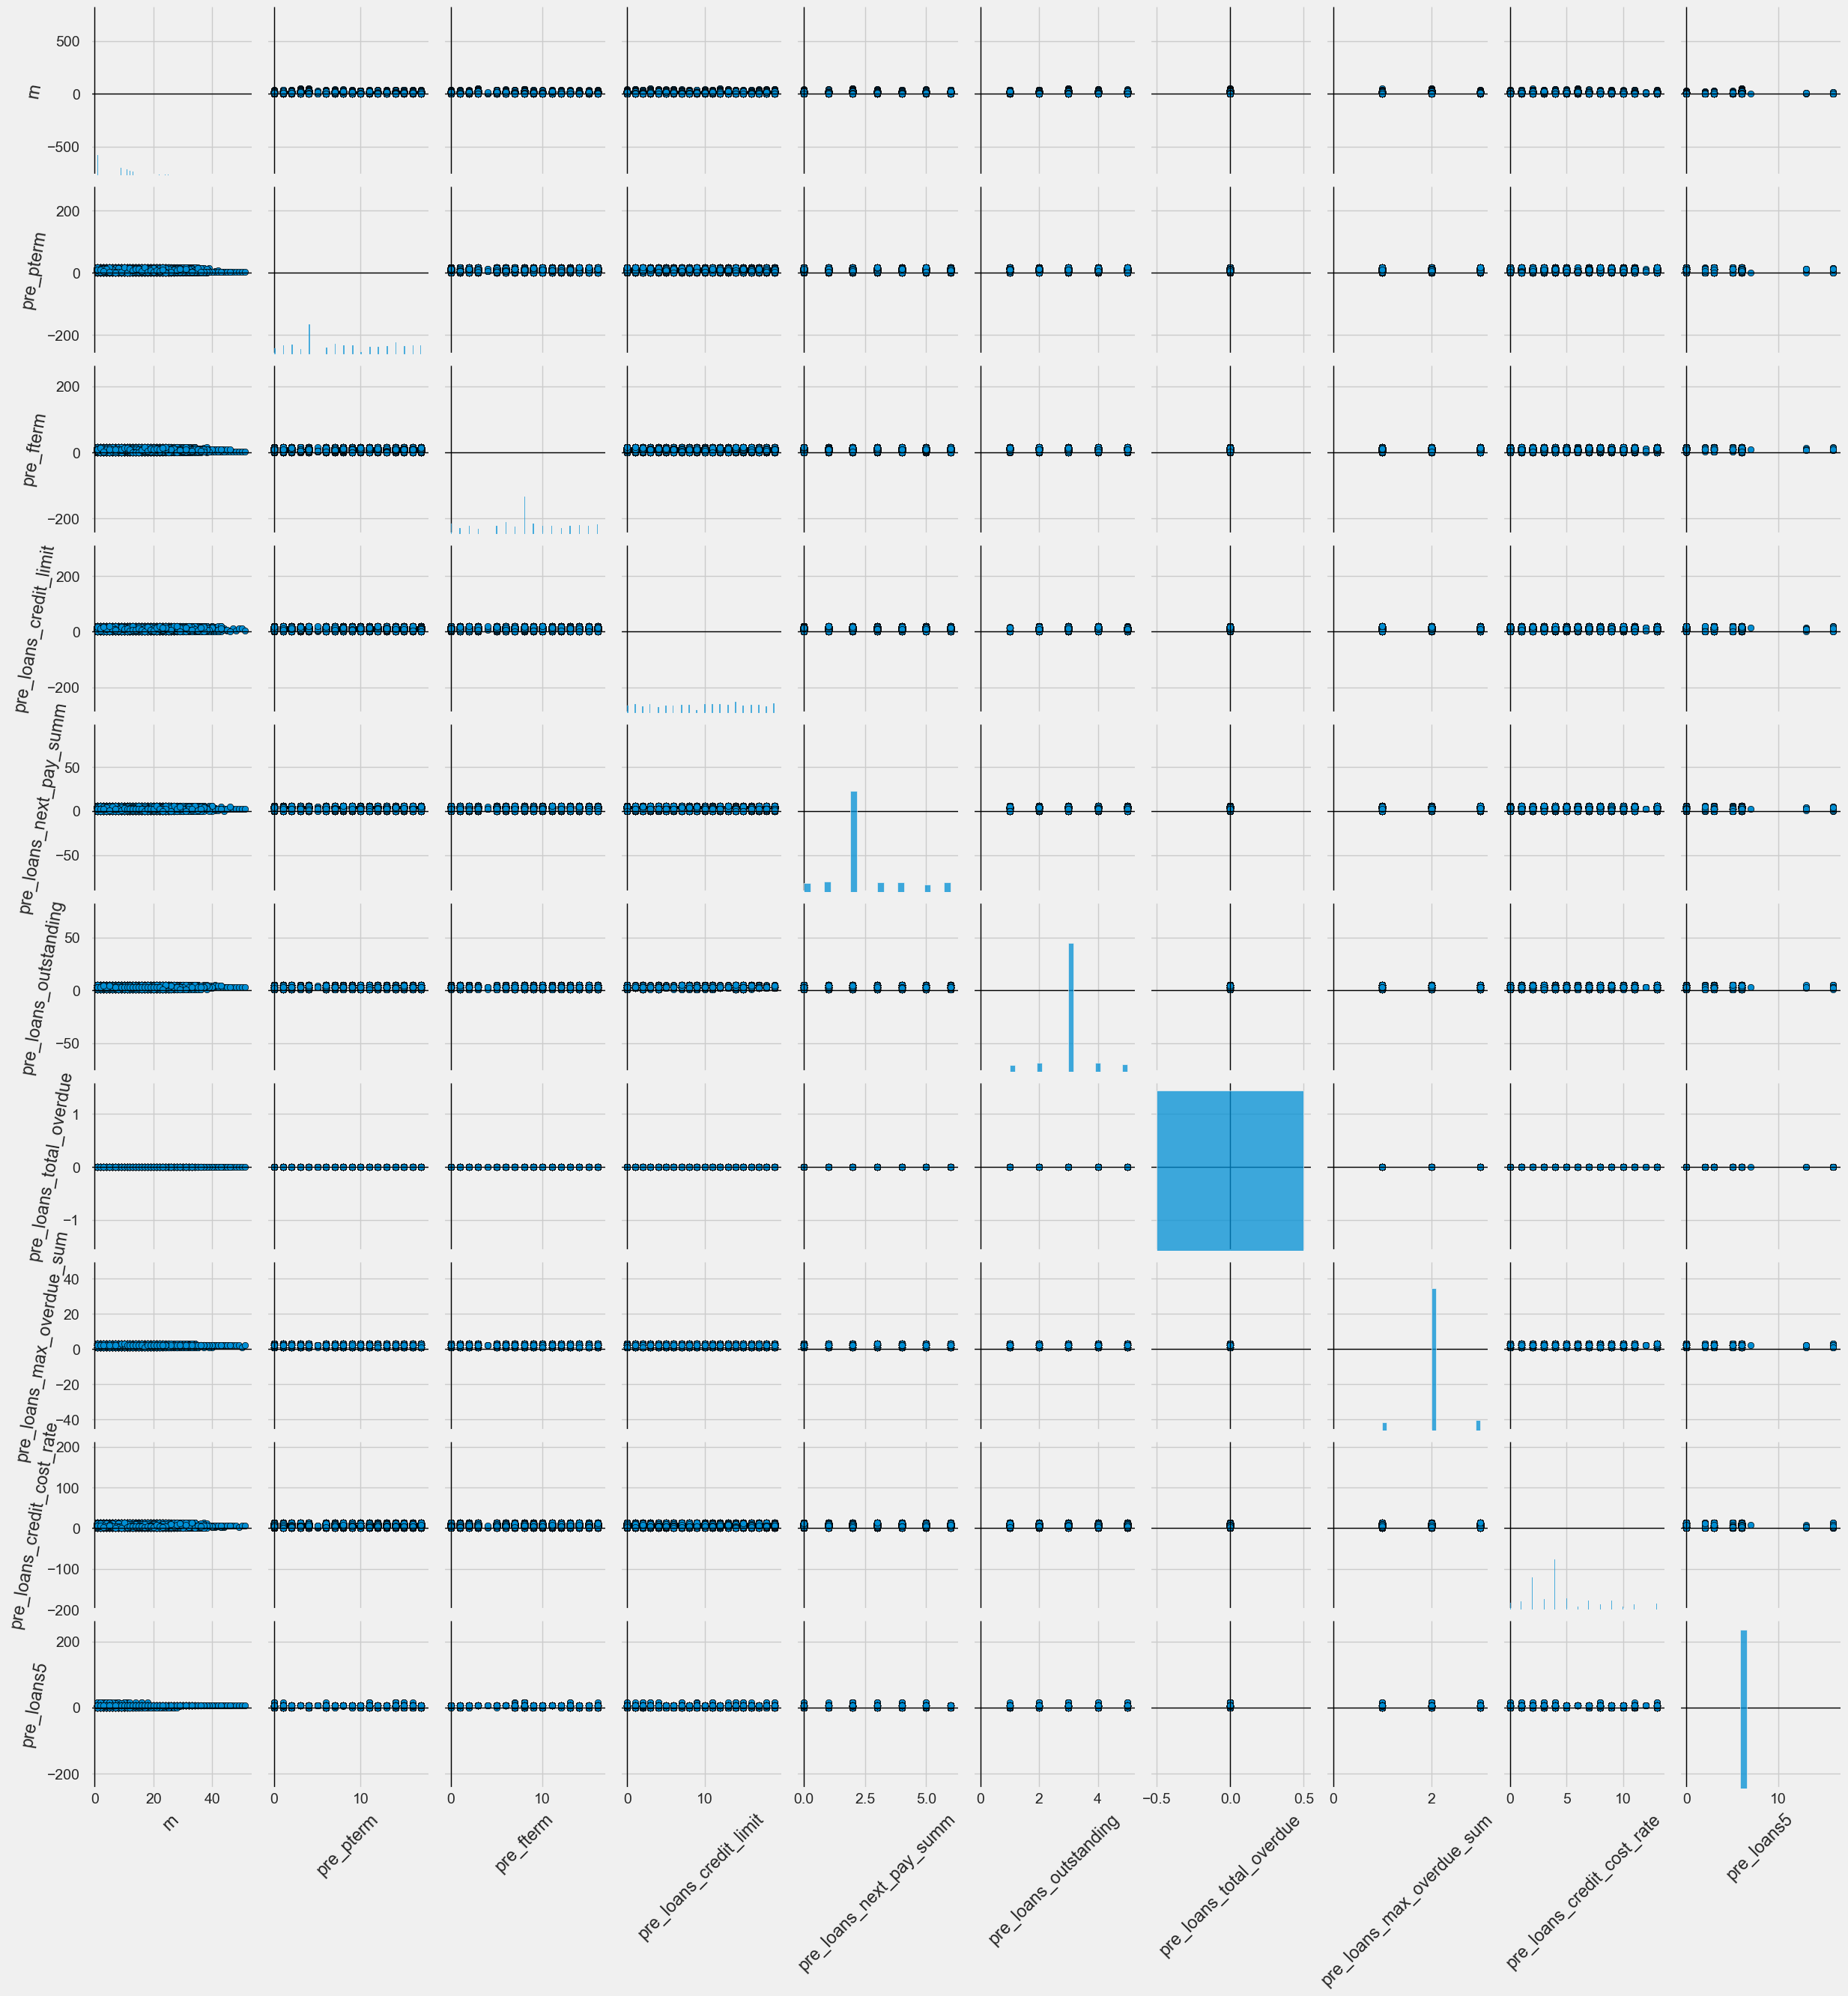

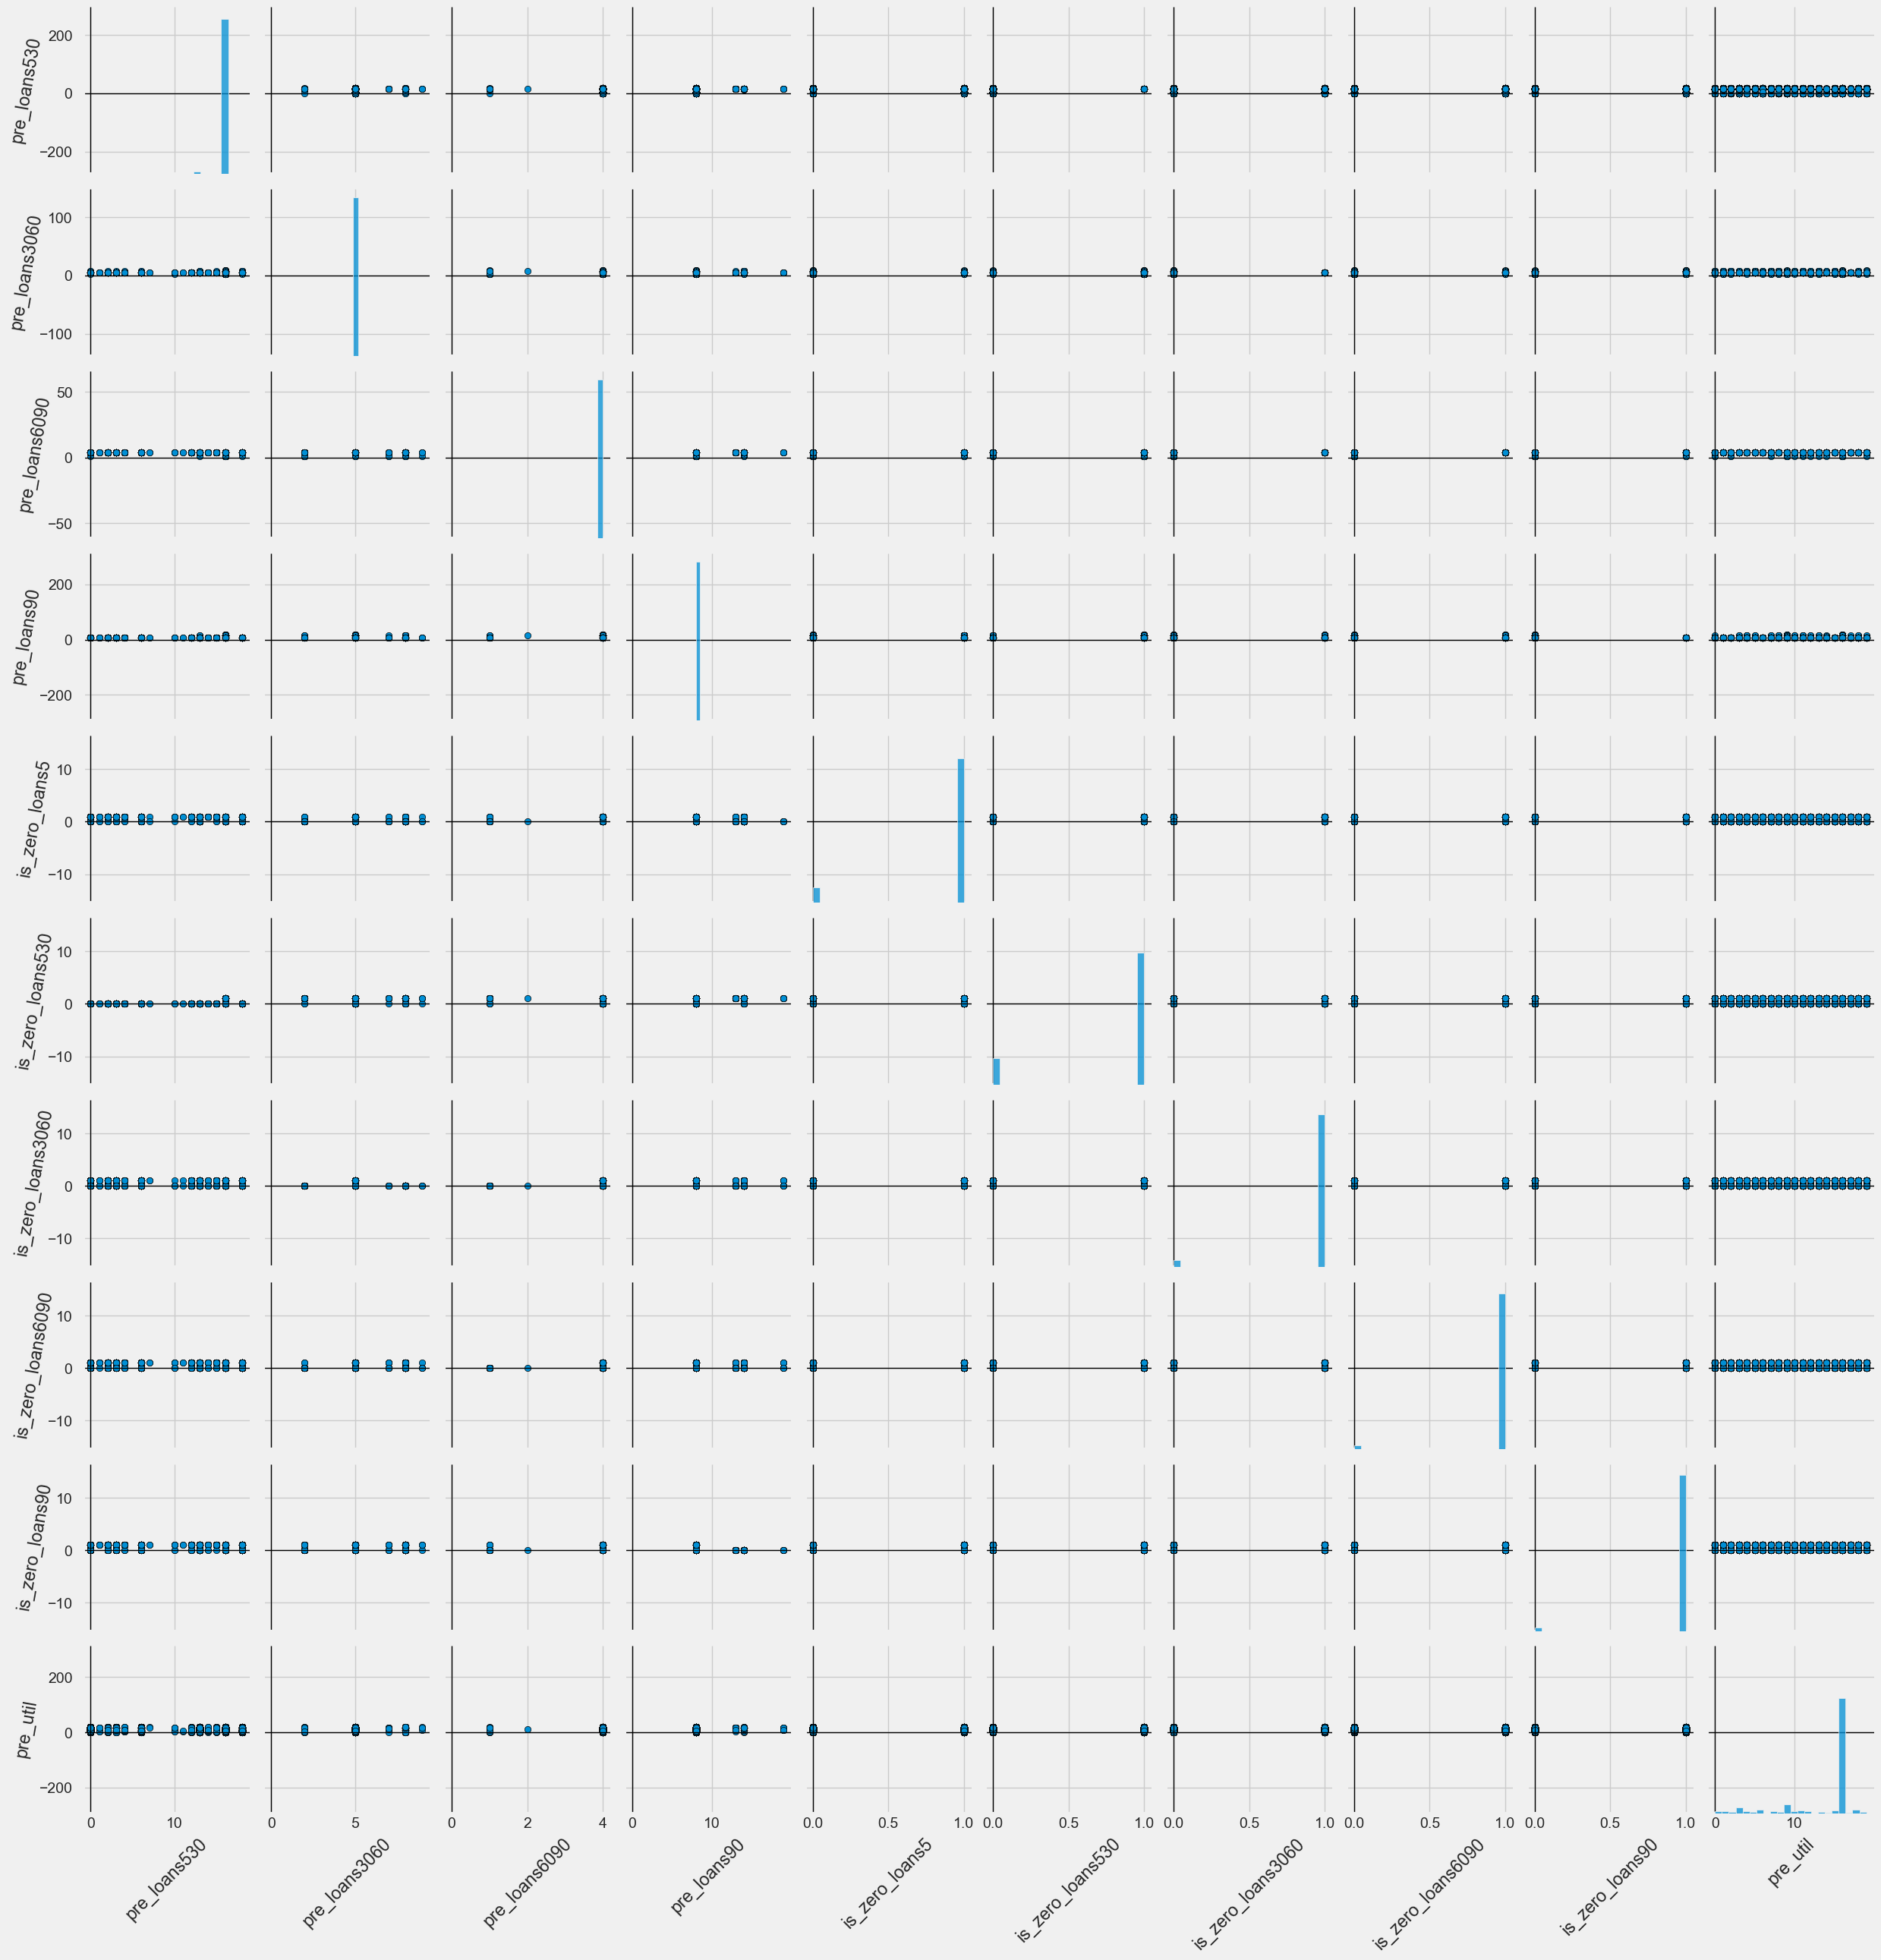

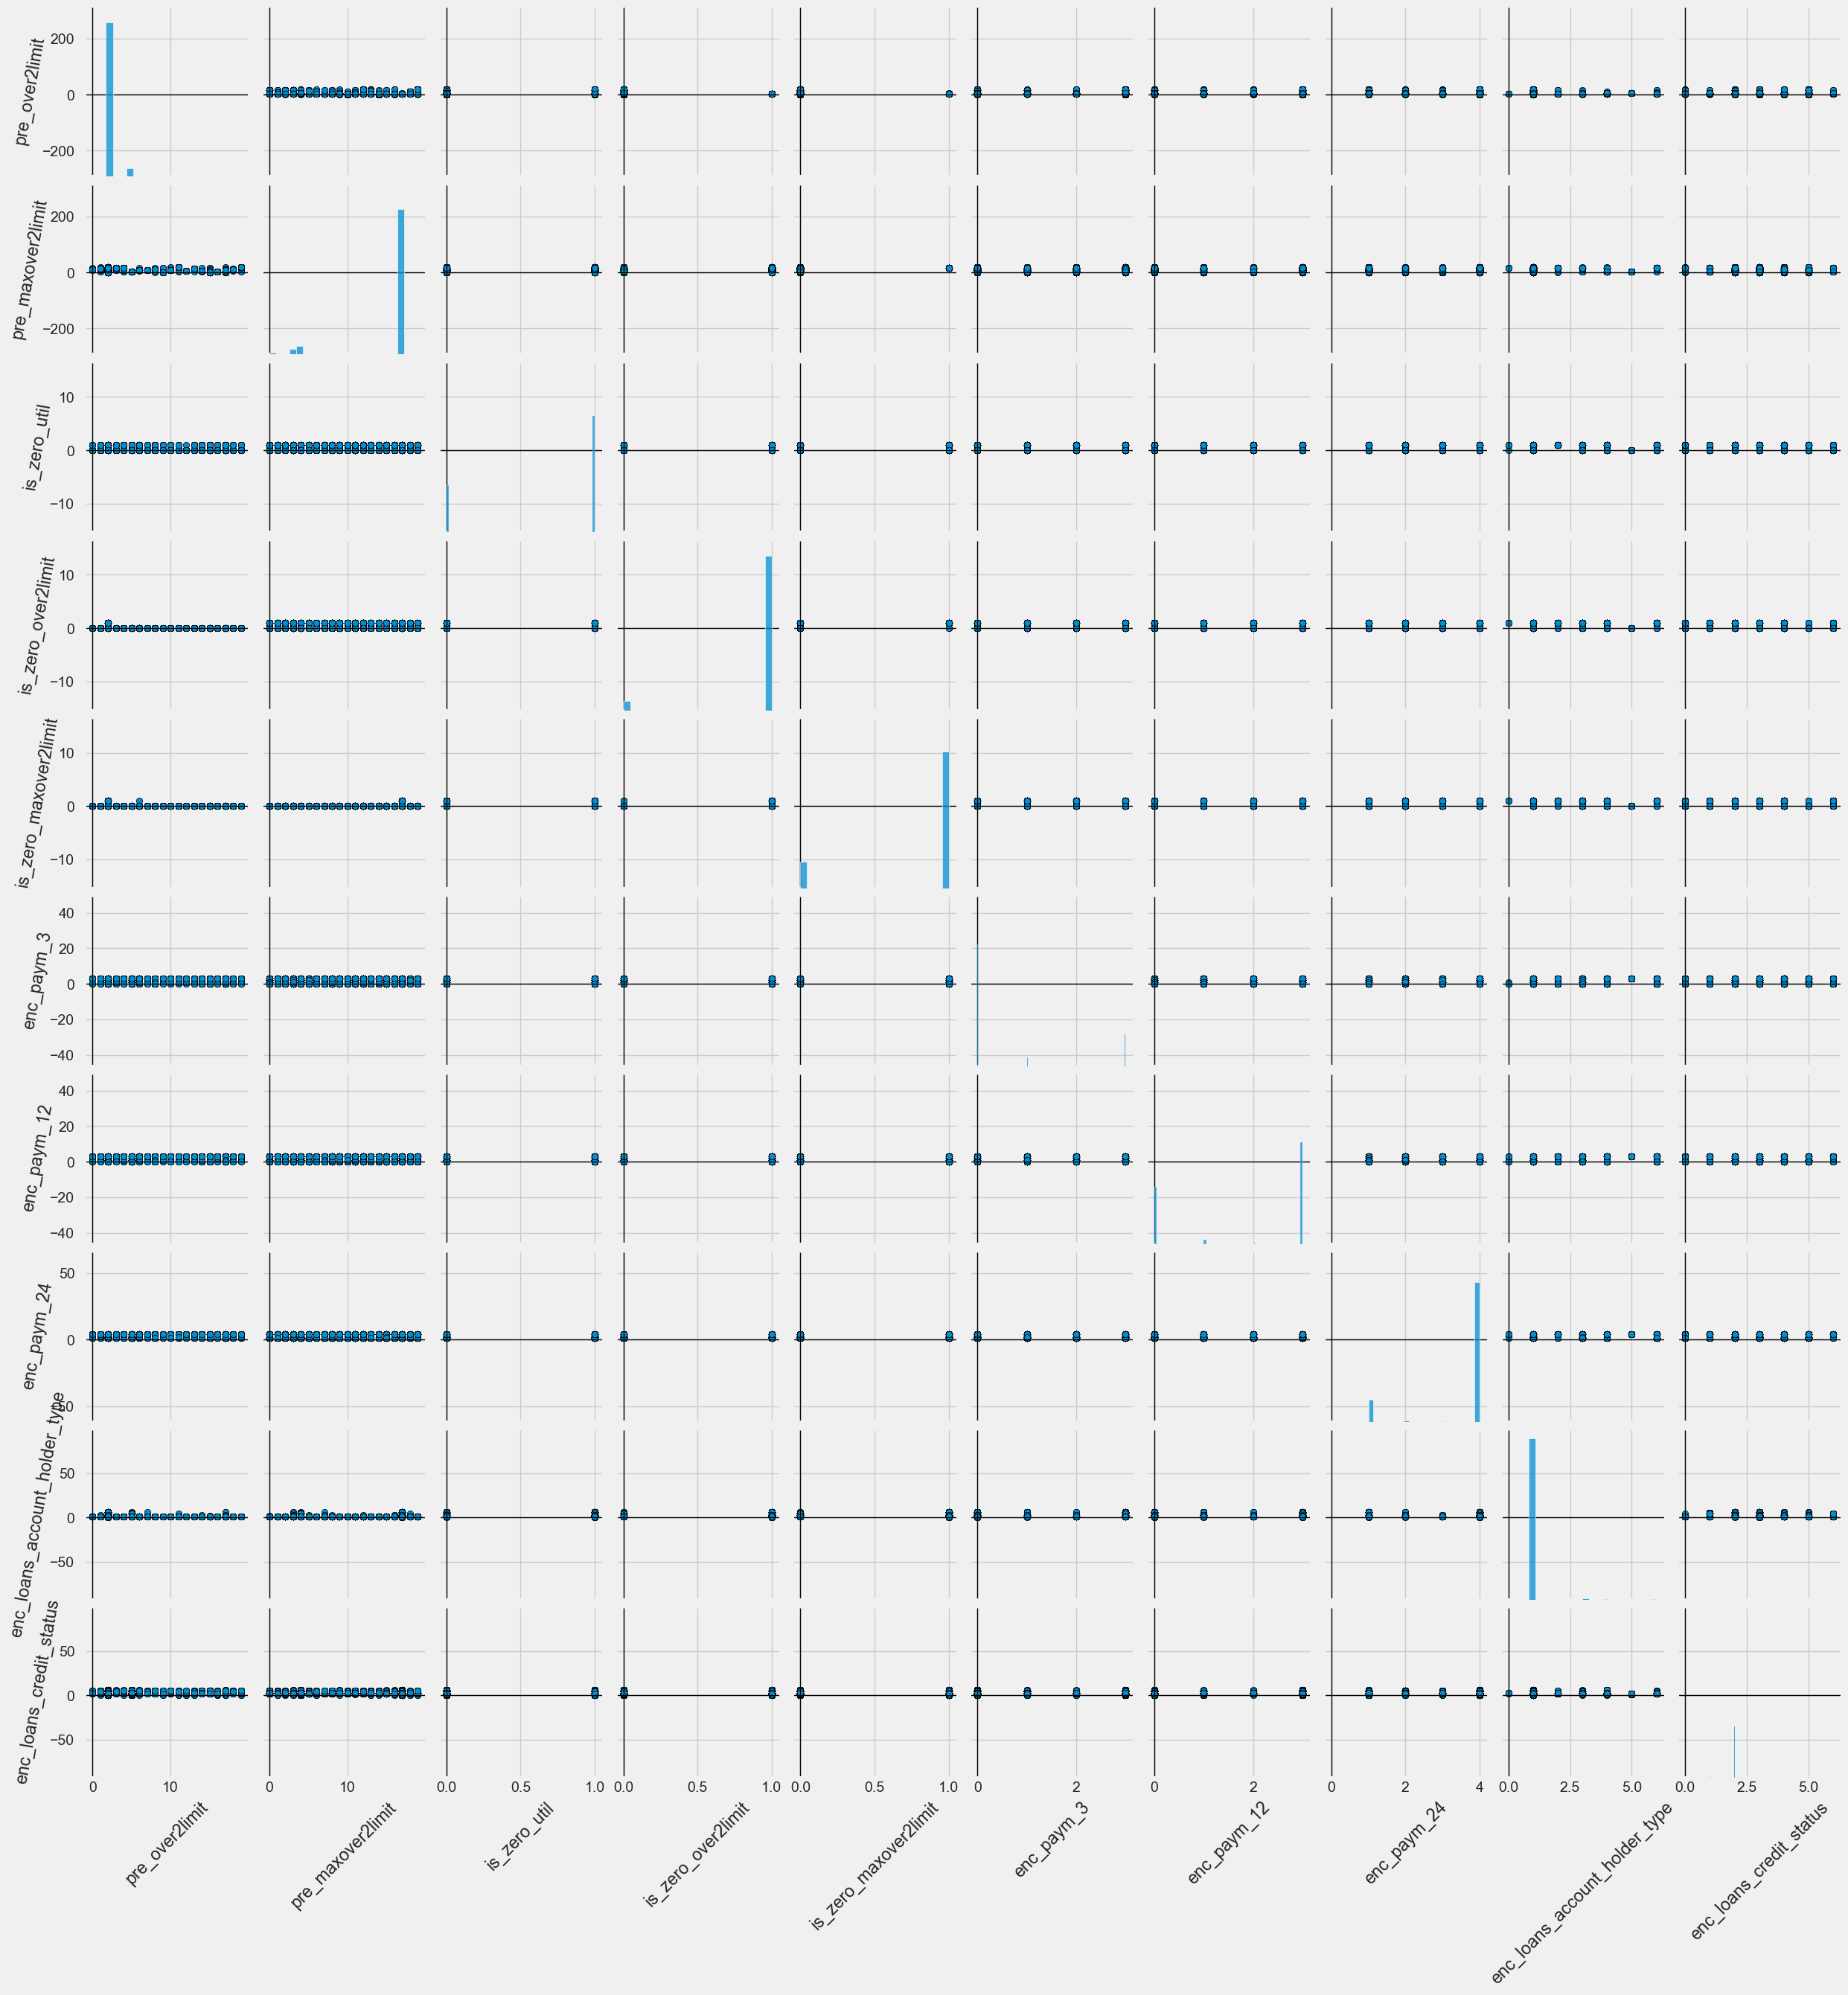

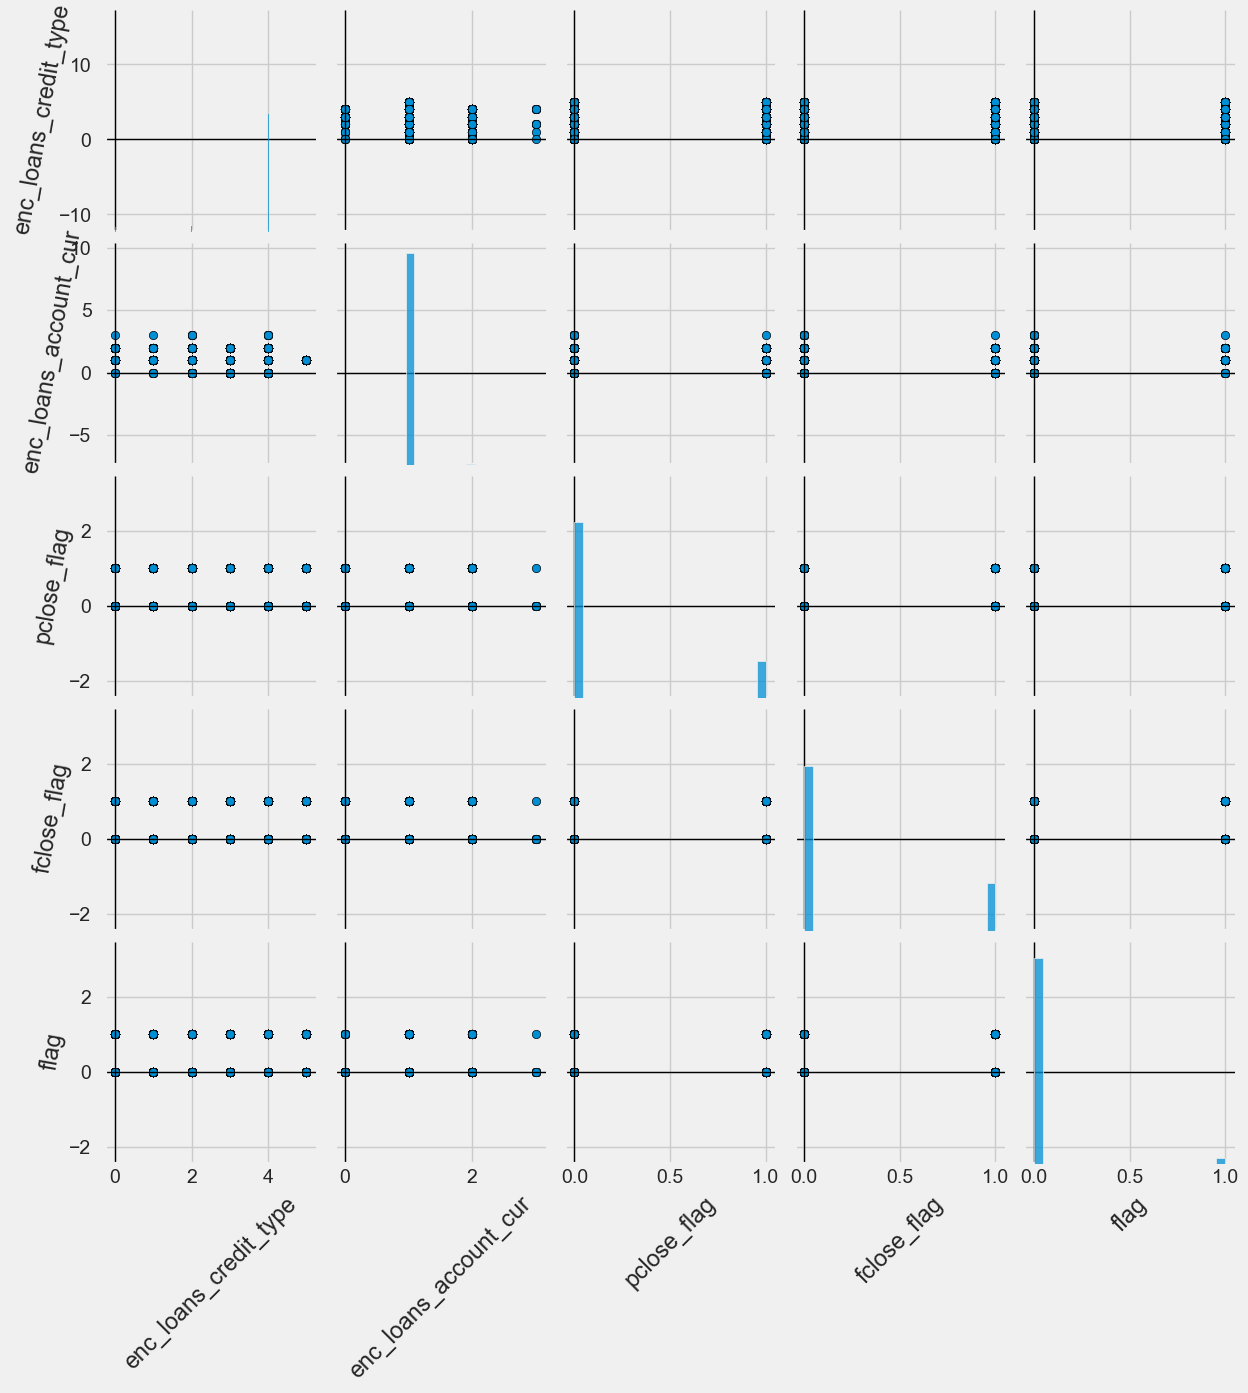

In [40]:
# Pairplot становится нечитаемым при использовании всего датасета целиком, поэтому поделим его на группы по 10 признаков и посмотрим на отношение признаков по меньшей мере в таком виде.
def add_gridlines(g):
    for ax in g.axes.flatten():
        # Добавляем горизонтальные и вертикальные линии между графиками
        ax.axhline(0, color="black", linewidth=1)
        ax.axvline(0, color="black", linewidth=1)

groups = [df.columns[i:i + 10] for i in range(0, len(df.columns), 10)]

# Создание pairplot для каждой группы и поворот меток
for group in groups:
    g = sns.pairplot(df[group], plot_kws={"edgecolor": "k", "linewidth": 0.5})
    add_gridlines(g)
    for ax in g.axes.flatten():
        ax.set_xlabel(ax.get_xlabel(), rotation=45)
        ax.set_ylabel(ax.get_ylabel(), rotation=80)

        ax.tick_params(axis='y', pad=10)
        ymin, ymax = ax.get_ylim()
        ax.set_ylim(ymin - 0.2 * (ymax - ymin), ymax + 0.2 * (ymax - ymin))
        
    plt.show()

Из графиков можно сделать вывод, что особо никаких зависимостей не просматривается. Наличие выбросов тоже под вопросом, распределение меток довольно близко друг к другу. 
_____________________________
Случайный лес, на мой взгляд, самая стандартная модель для классификации, с учетом дизбаланса классов. Его можно использовать в качестве бейслайна. Здесь зададим модель с использованием данных после undersampling. Также он не требователен к данным, то есть нет необходимости использовать Scaler. Склонен к переобучению, но я не думаю, что мы получим какой-либо адекватный результат на данном этапе, поэтому для бейслайна, чтобы посмотреть как модель и данные в целом работают, лучший вариант. 

Fitting 3 folds for each of 384 candidates, totalling 1152 fits
Лучшие параметры: {'class_weight': 'balanced_subsample', 'criterion': 'gini', 'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 160}
ROC AUC: 0.6187196600964805
Матрица ошибок:
[[8039 3509]
 [5181 6114]]


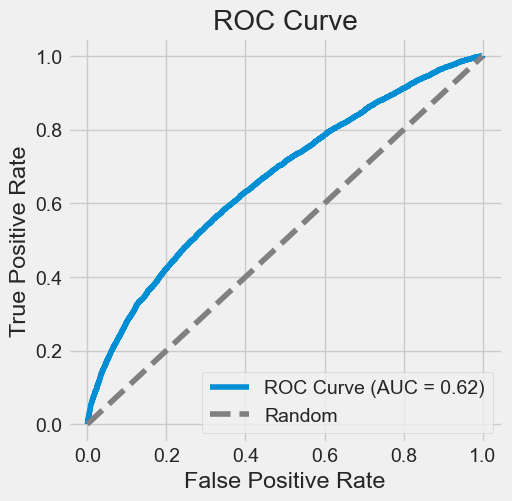

In [17]:
# Определение параметров для Grid Search
X_train, X_test, y_train, y_test = train_test_split(X_downscaled, y_downscaled, test_size=0.2, random_state=42)

param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [2, 4],
    'max_features': ['sqrt', 'log2'],
    'class_weight': [None, 'balanced', 'balanced_subsample'],
    'n_estimators': np.arange(10, 200, 50)
}

# Создание экземпляра RandomForestClassifier
rf = RandomForestClassifier(random_state=42)

# Создание объекта GridSearchCV
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, scoring='roc_auc', cv=3, verbose=1, n_jobs=-1)

# Обучение модели с Grid Search
grid_search.fit(X_train, y_train)

# Получение лучших параметров
best_params = grid_search.best_params_
print(f'Лучшие параметры: {best_params}')
# Получение предсказаний на тестовом наборе данных
y_pred = grid_search.predict(X_test)

# Вывод ROC AUC
roc_auc = roc_auc_score(y_test, y_pred)
print(f'ROC AUC: {roc_auc}')

# Вывод матрицы ошибок
conf_matrix = confusion_matrix(y_test, y_pred)
print(f'Матрица ошибок:\n{conf_matrix}')

# Вывод ROC-кривой
fpr, tpr, thresholds = roc_curve(y_test, grid_search.predict_proba(X_test)[:, 1])
plt.figure(figsize=(5, 5))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()


Fitting 3 folds for each of 384 candidates, totalling 1152 fits
Лучшие параметры: {'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 160}
ROC AUC: 0.6181855420944095
Матрица ошибок:
[[8042 3506]
 [5196 6099]]


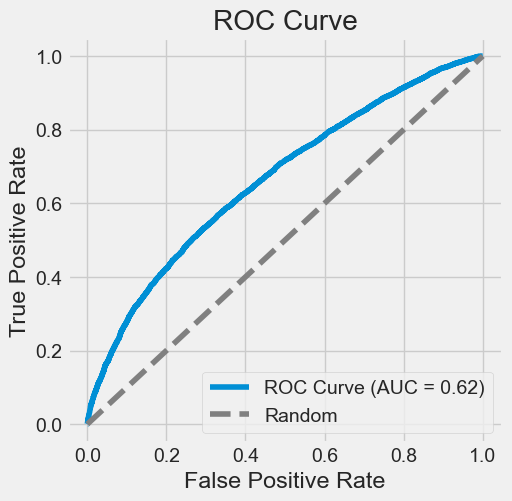

In [20]:
scaler = StandardScaler()
scaled_data = scaler.fit_transform(X_downscaled)
# Создание нового DataFrame с отмасштабированными данными
data_scaled = pd.DataFrame(scaled_data, columns=X_downscaled.columns)

X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled = train_test_split(data_scaled, y_downscaled, test_size=0.2, random_state=42)

param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [2, 4],
    'max_features': ['sqrt', 'log2'],
    'class_weight': [None, 'balanced', 'balanced_subsample'],
    'n_estimators': np.arange(10, 200, 50)
}

# Создание экземпляра RandomForestClassifier
rf_scaled = RandomForestClassifier(random_state=42)

# Создание объекта GridSearchCV
grid_search_scaled = GridSearchCV(estimator=rf_scaled, param_grid=param_grid, scoring='roc_auc', cv=3, verbose=1, n_jobs=-1)

# Обучение модели с Grid Search
grid_search_scaled.fit(X_train_scaled, y_train_scaled)

# Получение лучших параметров
best_params_scaled = grid_search_scaled.best_params_
print(f'Лучшие параметры: {best_params_scaled}')
# Получение предсказаний на тестовом наборе данных
y_pred_scaled = grid_search_scaled.predict(X_test_scaled)

# Вывод ROC AUC
roc_auc_scaled = roc_auc_score(y_test_scaled, y_pred_scaled)
print(f'ROC AUC: {roc_auc_scaled}')

# Вывод матрицы ошибок
conf_matrix_scaled = confusion_matrix(y_test_scaled, y_pred_scaled)
print(f'Матрица ошибок:\n{conf_matrix_scaled}')

# Вывод ROC-кривой
fpr, tpr, thresholds = roc_curve(y_test_scaled, grid_search_scaled.predict_proba(X_test_scaled)[:, 1])
plt.figure(figsize=(5, 5))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc_scaled:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

Fitting 3 folds for each of 60 candidates, totalling 180 fits
Лучшие параметры: {'class_weight': None, 'criterion': 'gini', 'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 180}
ROC AUC: 0.5
Матрица ошибок:
[[383494      0]
 [ 11451      0]]


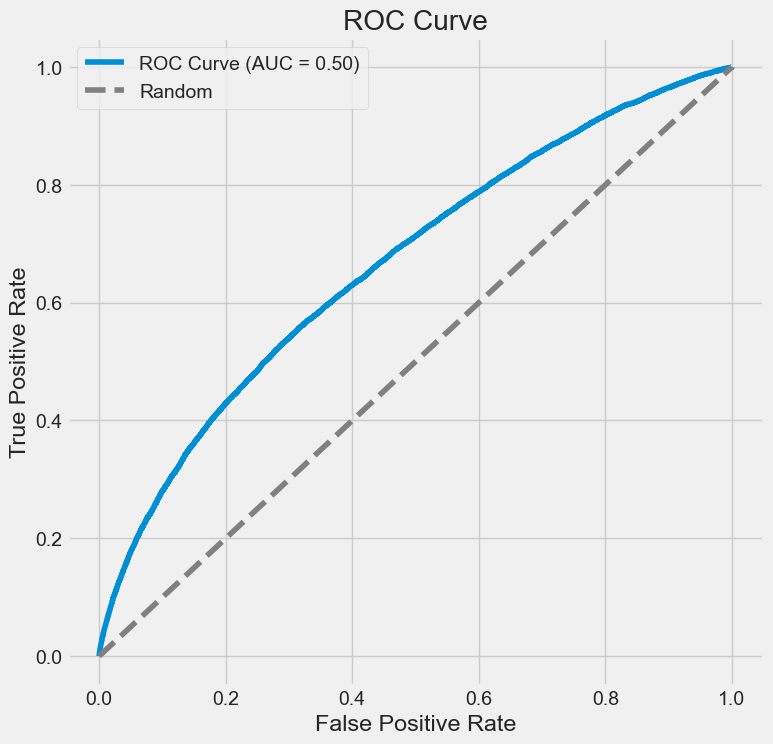

In [21]:
# Определение параметров для Grid Search
# Посмотрим на модель для дефолтных параметров без балансировки классов. 

X_train_defolt, X_test_defolt, y_train_defolt, y_test_defolt = train_test_split(X, y, test_size=0.2, random_state=42)

param_grid_for_defolt = {
    'criterion': ['gini'],
    'max_depth': [20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [2, 4],
    'max_features': ['sqrt'],
    'class_weight': [None, 'balanced', 'balanced_subsample'],
    'n_estimators': np.arange(100, 200, 20)
}

# Создание экземпляра RandomForestClassifier
rf_defolt = RandomForestClassifier(random_state=42)

# Создание объекта GridSearchCV
grid_search_defolt = GridSearchCV(estimator=rf_defolt, param_grid=param_grid_for_defolt, scoring='roc_auc', cv=3, verbose=1, n_jobs=-1)

# Обучение модели с Grid Search
grid_search_defolt.fit(X_train_defolt, y_train_defolt)

# Получение лучших параметров
best_params_defolt = grid_search_defolt.best_params_
print(f'Лучшие параметры: {best_params_defolt}')
# Получение предсказаний на тестовом наборе данных
y_pred_defolt = grid_search_defolt.predict(X_test_defolt)

# Вывод ROC AUC
roc_auc_defolt = roc_auc_score(y_test_defolt, y_pred_defolt)
print(f'ROC AUC: {roc_auc_defolt}')

# Вывод матрицы ошибок
conf_matrix_defolt = confusion_matrix(y_test_defolt, y_pred_defolt)
print(f'Матрица ошибок:\n{conf_matrix_defolt}')

# Вывод ROC-кривой
fpr, tpr, thresholds = roc_curve(y_test_defolt, grid_search_defolt.predict_proba(X_test_defolt)[:, 1])
plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc_defolt:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()


Этот ноутбук можно считать за бейслайн. Проблематично прогружать графики каждый раз при ошибке кода, по этому я оставляю его в таком виде. 

Видим, что масштабирование не дает никакого эффекта. Достаточно большое количество ошибок при сбалансированных данных. Построение модели на дефолтных данных вообще не предсказывает 1. 